In [2]:
# To load the library
import src.rmf_tool as rmf
import time 

import importlib
importlib.reload(rmf)

# to numerically integrate the ODE
import scipy.integrate as integrate

# To plot the results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# This code creates an object that represents a "density dependent population process"
ddpp = rmf.DDPP() 
# We then add the three transitions : 
ddpp.add_transition([-1,1],lambda x: x[0]*(1 + 10*x[1]/(a+x[0])))
ddpp.add_transition([0,-1],lambda x: 5*x[1])
ddpp.add_transition([1,0],lambda x: (10*x[0] + 0.1)*(1-x[0]-x[1]))
#ddpp.add_transition([1,0,-1],lambda x: (10*x[0] + 0.1)*x[2])
#(1-x[0]-x[1]))
#x[2])


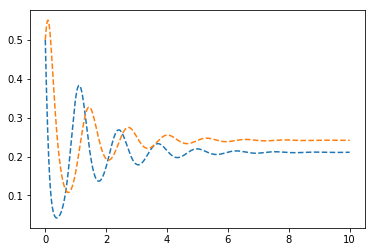

In [4]:
ddpp.set_initial_state([.5,.5])
a=0.3
T,X = ddpp.ode(time=10)
plt.plot(T,X,'--')

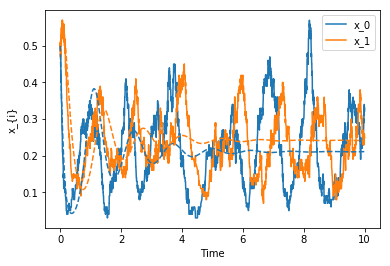

In [5]:
ddpp.plot_ODE_vs_simulation(N=100,time=10)

In [6]:
ddpp.fixed_point() #(N=10)
ddpp.theoretical_V()

array([ 3.21918611, -2.03261442])

In [7]:
from scipy.interpolate import interp1d
import os
import os.path

def averageTraj(N,a,nbSamples=1000):
    os.system('cd ../refined_meanField_transientAnalysis/simu/SIRd_simulate/ && make')
    fileName = 'traj/trajN{}a{}.npz'.format(N,a)
    if os.path.exists(fileName):
        results = np.load(fileName)
        nbSamplesComputed = results['nbSamples']
        T = results['T']
        S = results['S']
        I = results['I']
        if nbSamplesComputed > nbSamples: return(T,S/nbSamplesComputed,I/nbSamplesComputed)
    else:
        nbSamplesComputed = 0
        S = np.zeros(1000)
        I = np.zeros(1000)
    T = np.linspace(0,10,1000)
    ti = time.time()
    for i in range(nbSamplesComputed,nbSamples):
        os.system('../refined_meanField_transientAnalysis/simu/SIRd_simulate/sir_simu N{0} a{1} t > tmp_N{0}_a{1}'.format(N,a))
        result = np.array(pd.read_csv('tmp_N{0}_a{1}'.format(N,a),sep=' ',header=None))
        f_S = interp1d(result[:,0],result[:,1],kind='zero',assume_sorted=True)
        f_I = interp1d(result[:,0],result[:,2],kind='zero',assume_sorted=True)
        #print(i)
        S += f_S(T)
        I += f_I(T)
    np.savez(fileName,nbSamples=nbSamples,T=T,S=S,I=I)
    print(N,a,'computed in ',time.time()-ti,'seconds')
    results = np.load(fileName)
    return(results['T'],results['S']/nbSamples,results['I']/nbSamples)

def steadyState(N,a):
    os.system('cd ../refined_meanField_transientAnalysis/simu/SIRd_simulate/ && make')
    fileName = 'traj/steadyStateN{}a{}.txt'.format(N,a)
    if not os.path.exists(fileName):
        os.system('../refined_meanField_transientAnalysis/simu/SIRd_simulate/sir_simu N{0} a{1} > {2}'.format(
            N,a,fileName))
    return np.mean(np.loadtxt(fileName),0)


10 0.1 computed in  0.0035228729248046875 seconds
50 0.1 computed in  0.0020301342010498047 seconds
Time ODE 0.023563861846923828
Time ODE RMF 0.6795079708099365


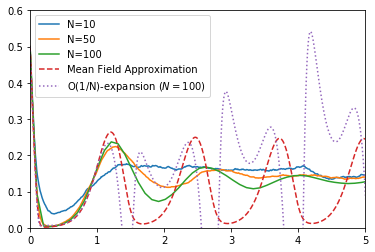

In [22]:
f = plt.figure()
a=0.1
myN = [10,50,100]
for N in myN:
    t,s,i = averageTraj(N,a,1000)
    plt.plot(t,s)
T,X = ddpp.ode(time=10)
plt.plot(T,X[:,0],'--')

T,X,XVW = ddpp.refinedTransient(time=10)
plt.plot(T,X[:,0]+XVW[:,3] / N,':')
legds.append('Mean Field Approximation')
legds.append('O(1/N)-expansion ($N=100$)')
plt.legend(legds,loc='upper left')
plt.xlim([0,5])
plt.ylim([0,.6])
f.savefig('SIR_a01.pdf',bbox_inches='tight')

Time ODE 0.20406579971313477
Time ODE RMF 7.241155624389648


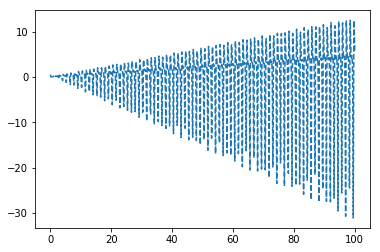

In [24]:
T,X,XVW = ddpp.refinedTransient(time=100)
plt.plot(T,XVW[:,0]+XVW[:,3]/N,'--')
#t,s,i = averageTraj(N,a,1000)
#plt.plot(t,s)

10 0.3 computed in  0.0016109943389892578 seconds
50 0.3 computed in  0.0015780925750732422 seconds
Time ODE 0.009391069412231445
Time ODE RMF 0.2601301670074463


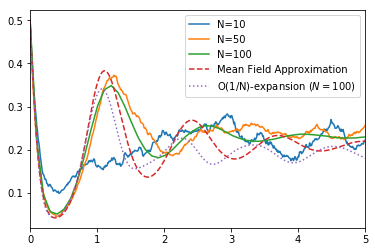

In [25]:
f = plt.figure()
a=0.3
myN = [10,50,100]
for N in myN:
    t,s,i = averageTraj(N,a,100)
    plt.plot(t,s)
T,X = ddpp.ode(time=10)
plt.plot(T,X[:,0],'--')

T,X,XVW = ddpp.refinedTransient(time=10)
plt.plot(T,X[:,0]+XVW[:,3] / 100,':')
legds= ['N={}'.format(N) for N in myN]
legds.append('Mean Field Approximation')
legds.append('O(1/N)-expansion ($N=100$)')
plt.legend(legds)
plt.xlim([0,5])
f.savefig('SIR_a03.pdf',bbox_inches='tight')

In [11]:
#N=1000
#T,X=ddpp.simulate(N=N,time=1)
#os.system('../refined_meanField_transientAnalysis/simu/SIRd_simulate/sir_simu N{0} a{1} > tmp_N{0}_a{1}'.format(N,a))
#result = np.array(pd.read_csv('tmp_N{0}_a{1}'.format(N,a),sep=' ',header=None))
#
#plt.plot(T,X[:,0],'--')
#plt.plot(result[:,0],result[:,1],':')
#plt.legend(('RMF tool','C++ code'))
#plt.xlim([0,1])

In [10]:
a=0.3
i=1
T,X,XVW=ddpp.refinedTransient(time=1000)
print('  N & Mean-field & O(1/N)-expansion & Simulation')
for N in [10,20,30,50,100,500,1000,2000]:
    print('{:4d} & {:.3f}\t & {:.3f} \t\t& {:.3f}\\\\'.format(
        N, X[-1,i], X[-1,i]+XVW[-1,3+i]/N, steadyState(N,a)[i]) )
    
pi = ddpp.fixed_point()
for N in [10,20,30,50,100,500,1000,2000]:
    print(N,N*(steadyState(N,a)-pi))

Time ODE 0.018728017807006836
Time ODE RMF 0.4862189292907715
  N & Mean-field & O(1/N)-expansion & Simulation
  10 & 0.242	 & 0.495 		& 0.122\\
  20 & 0.242	 & 0.368 		& 0.165\\
  30 & 0.242	 & 0.326 		& 0.186\\
  50 & 0.242	 & 0.292 		& 0.207\\
 100 & 0.242	 & 0.267 		& 0.224\\
 500 & 0.242	 & 0.247 		& 0.238\\
1000 & 0.242	 & 0.244 		& 0.240\\
2000 & 0.242	 & 0.243 		& 0.241\\
10 [ 0.04060385 -1.19354788]
20 [ 0.4767847  -1.53261115]
30 [ 0.83054955 -1.66581743]
50 [ 1.33953324 -1.75649188]
100 [ 1.97966649 -1.78721976]
500 [ 2.87901744 -1.91127381]
1000 [ 2.92981489 -2.01587762]
2000 [ 3.19966978 -1.95839524]


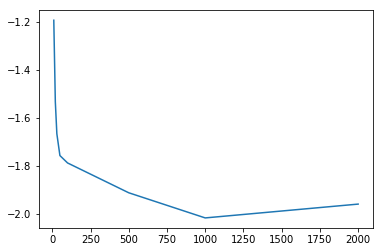

In [11]:
i=1
myN = [10,20,30,50,100,500,1000,2000]
mySS = [steadyState(N,a)[i] for N in myN]
plt.plot(myN,myN*(mySS-X[-1,i]))

## Refined refined

The drift (on a 2-dim model) is: 
* d x_0 = - x[0]*(1 + 10*x[1]/(a+x[0])) + (10*x[0] + 0.1)*x[2]


In [26]:
import sympy as sym

exec(open('../refined_meanField_transientAnalysis/simu/refinedRefined_transientRegime.py').read())
def refinedTransient(a,order=1,time=10):
    list_of_transitions = [ np.array(l) for l in [[-1,1],[0,-1],[1,0]]]
    rates = [ lambda x : x[0]*( 1 + 10*x[1]/(a+x[0]) ), 
             lambda x : 5*x[1],
            lambda x : (10*x[0] + 0.1)*(1-x[0]-x[1]) ]
    n=len(list_of_transitions[0])
    x = [sym.symbols('x[{}]'.format(i)) for i in range(n)]

    f=np.zeros(n)
    for l in range(len(list_of_transitions)):
        f = f + list_of_transitions[l]*rates[l](x)
    dF = np.array([[sym.diff(f[i],x[j]) for j in range(n)] for i in range(n)]).reshape((n**2))
    ddF = np.array([[sym.diff(f[i],x[j],x[k]) for j in range(n) for k in range(n)] for i in range(n)]).reshape((n**3))
    dddF = np.array([[sym.diff(f[i],x[j],x[k],x[l]) for j in range(n) for k in range(n) for l in range(n)] 
                     for i in range(n)]).reshape((n**4))
    ddddF = np.array([[sym.diff(f[i],x[j],x[k],x[l],x[m]) for j in range(n) for k in range(n) for l in range(n) for m in range(n)] 
                     for i in range(n)]).reshape((n**5))
    q = np.zeros((n**2))
    for l in range(len(list_of_transitions)):
        q = q + np.kron(list_of_transitions[l],list_of_transitions[l])*rates[l](x)
    r = np.zeros((n**3))
    for l in range(len(list_of_transitions)):
        r = r + np.kron(list_of_transitions[l],np.kron(list_of_transitions[l],list_of_transitions[l]))*rates[l](x)
    dQ = np.array( [[[sym.diff(q[i],x[k]) for k in range(n)] for i in range(n**2)]] ).reshape(n**3)
    ddQ = np.array( [[[sym.diff(q[i],x[k],x[l]) for k in range(n) for l in range(n)] for i in range(n**2)]] ).reshape(n**4)

    F = sym.lambdify([x],[f[i] for i in range(n)])
    Fp = sym.lambdify([x],[dF[i] for i in range(n**2)])
    Fpp = sym.lambdify([x],[ddF[i] for i in range(n**3)])
    Fppp = sym.lambdify([x],[dddF[i] for i in range(n**4)])
    Fpppp = sym.lambdify([x],[ddddF[i] for i in range(n**5)])
    Q = sym.lambdify([x],[q[i] for i in range(n*n)])
    Qp = sym.lambdify([x],[dQ[i] for i in range(n**3)])
    Qpp = sym.lambdify([x],[ddQ[i] for i in range(n**4)])
    R = sym.lambdify([x],[r[i] for i in range(n**3)])        

    def computeF(x):     return(np.array(F(x)))
    def computeFp(x):    return(np.array(Fp(x)).reshape( (n,n) ))
    def computeFpp(x):   return(np.array(Fpp(x)).reshape( (n,n,n) ))
    def computeFppp(x):  return(np.array(Fppp(x)).reshape( (n,n,n,n) ))
    def computeFpppp(x): return(np.array(Fpppp(x)).reshape( (n,n,n,n,n) ))
    def computeQ(x):     return(np.array(Q(x)).reshape( (n,n) ))
    def computeQp(x):    return(np.array(Qp(x)).reshape( (n,n,n) ))
    def computeQpp(x):   return(np.array(Qpp(x)).reshape( (n,n,n,n) ))
    def computeR(x):     return(np.array(R(x)).reshape( (n,n,n) ))
        
    if order==1:
        XVW_0 = np.zeros(2*n+n**2)
        XVW_0[0] = 0.5
        XVW_0[1] = 0.5
    
        Tmax=time
        T = np.linspace(0,Tmax,1000)
    
        numericalInteg = integrate.solve_ivp( lambda t,x : 
                                             drift_r_vector(x,n,computeF,computeFp,computeFpp,computeQ), 
                                             [0,Tmax], XVW_0,t_eval=T)
        T = numericalInteg.t
        XVW = numericalInteg.y
        return(T,XVW)
    elif order==2:
        XVWABCD_0 = np.zeros(3*n+2*n**2+n**3+n**4)
        XVWABCD_0[0] = 0.5
        XVWABCD_0[1] = 0.5

        Tmax=time
        T = np.linspace(0,Tmax,1000)

        numericalInteg = integrate.solve_ivp( lambda t,x : 
                                             drift_rr_vector(x,n,computeF,computeFp,computeFpp,computeQ,
                                                    computeFppp,computeFpppp,computeQp,computeQpp,computeR), 
                                             [0,Tmax], XVWABCD_0,t_eval=T)
        T = numericalInteg.t
        XVWABCD = numericalInteg.y
        return(T,XVWABCD)
    else:
        print("order must be 1 (refined of order O(1/N)) or 2 (refined order 1/N^2)")

In [35]:
a=0.1
T,XVW = refinedTransient(a,1)
Ttool,Xtool,XVWtool = ddpp.refinedTransient(time=1000)


Time ODE 2.0009632110595703
Time ODE RMF 91.60357904434204


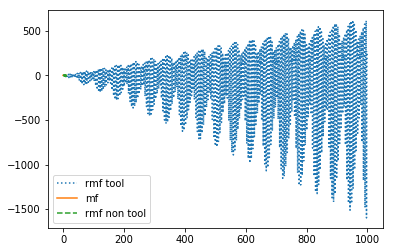

In [36]:
i=1
plt.plot(Ttool,Xtool[:,i]+XVWtool[:,i+ddpp._model_dimension] / 20,':')

plt.plot(T,XVW[i,:])
plt.plot(T,XVW[i,:]+XVW[i+2,:]/20,'--')
#if a==0.1:
#    plt.ylim([-1,2])
#    plt.xlim([0,5])
plt.legend(('rmf tool','mf','rmf non tool'))

### Refined model of order $1/N^2$ for the unstable SIR

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


50 [ 9.52840101 15.1295296 ]
100 [ 9.99945458 14.99979617]
200 0.1 computed in  0.0015909671783447266 seconds
200 [ 9.99972729 14.99989808]
500 0.1 computed in  0.0015158653259277344 seconds
500 [ 9.99989092 14.99995923]
1000 0.1 computed in  0.0014910697937011719 seconds
1000 [ 9.99994546 14.99997962]
50 [0.33767284 0.24296874]
100 [0.32483515 0.25623848]
200 0.5 computed in  0.0020279884338378906 seconds
200 [0.31841631 0.26287335]
500 0.5 computed in  0.0015621185302734375 seconds
500 [0.314565   0.26685427]
1000 0.5 computed in  0.0015478134155273438 seconds
1000 [0.31328123 0.26818124]


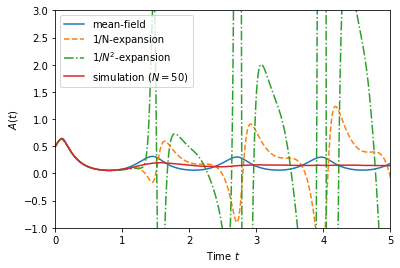

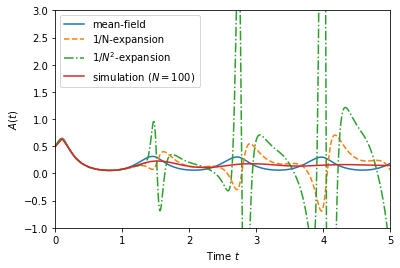

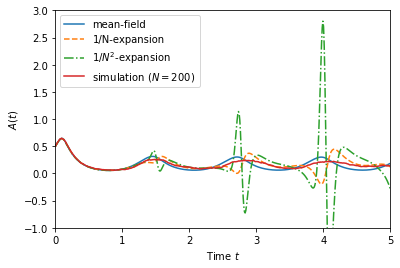

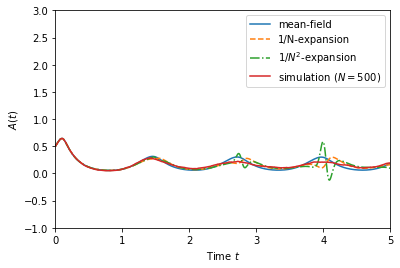

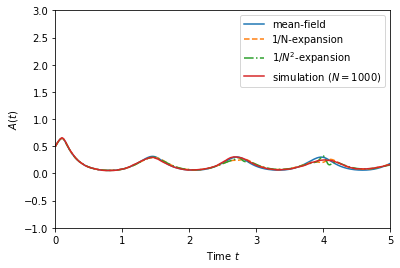

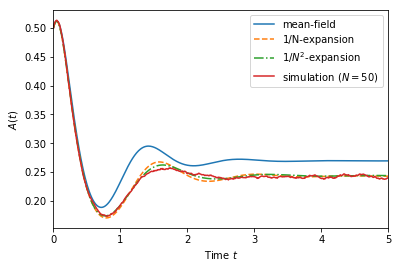

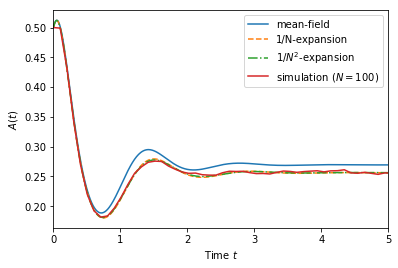

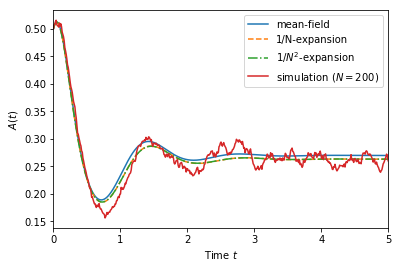

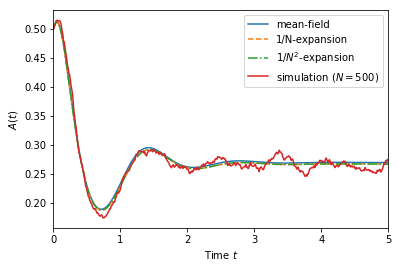

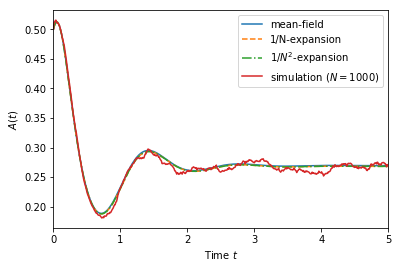

In [19]:

for a in [0.1,0.5]:
  T,XVWABCD = refinedTransient(a,order=2)
  #for N in [20,50]:
  for N in [50,100,200,500,1000]:
    f = plt.figure()
    i=1
    n=2
    plt.plot(T,XVWABCD[i,:])
    plt.plot(T,XVWABCD[i,:]+XVWABCD[i+n,:]/N,'--')
    plt.plot(T,XVWABCD[i,:]+XVWABCD[i+n,:]/N+XVWABCD[i+2*n+n**2,:]/N**2,'-.')
    Tsimu,Ssimu,Isimu = averageTraj(N,a,10)
    if i==0:
        plt.plot(Tsimu,Ssimu)
    else:
        plt.plot(Tsimu,Isimu)
    plt.legend(('mean-field','1/N-expansion','$1/N^2$-expansion','simulation ($N={}$)'.format(N)))
    plt.xlim([0,5])
    if a==0.1:
        plt.ylim([-1,3])
    if i==1:
        plt.ylabel('$A(t)$')
    elif i==0:
        plt.ylabel('$D(t)$')
    plt.xlabel('Time $t$')
    pi = ddpp.fixed_point() #(N=10)
    V = ddpp.theoretical_V()
    print(N,pi+V/N)
    f.savefig('SIR_a0{}_N{}.pdf'.format(int(a*10),N),bbox_inches='tight')


50 0.1 computed in  0.0017681121826171875 seconds
50 0.5 computed in  0.001741170883178711 seconds


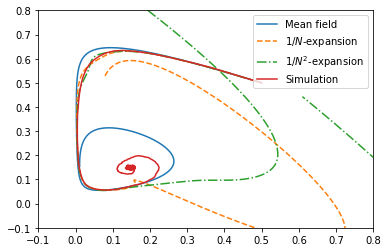

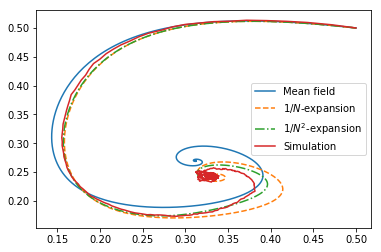

In [17]:

N=50

for a in [0.1,0.5]:
    if a == 0.1:
        T,XVWABCD = refinedTransient(a,order=2,time=1.7)
    else:
        T,XVWABCD = refinedTransient(a,order=2,time=5)
        
    Tsimu,Ssimu,Isimu = averageTraj(N,a,1000)
    #s,i = ddpp.simulate(N,time=5)
    
    f=plt.figure()
    plt.plot(XVWABCD[0,:],XVWABCD[1,:])
    plt.plot(XVWABCD[0,:]+XVWABCD[n,:]/N,
             XVWABCD[1,:]+XVWABCD[1+n,:]/N,'--')
    plt.plot(XVWABCD[0,:]+XVWABCD[n,:]/N+XVWABCD[2*n+n**2,:]/N**2,
             XVWABCD[1,:]+XVWABCD[1+n,:]/N+XVWABCD[1+2*n+n**2,:]/N**2,'-.')
    plt.plot(Ssimu,Isimu)
    plt.legend(('Mean field', '$1/N$-expansion','$1/N^2$-expansion','Simulation'))
    if a==0.1:
        plt.xlim([-.1,.8])
        plt.ylim([-.1,.8])
    f.savefig('SIR_2D_a0{}_N{}'.format(int(10*a),N),bbox_inches='tight')
#plt.plot(T,XVW[i,:]+XVW[i+n,:]/N)
#plt.plot(T,XVWABCD[i,:]+XVWABCD[i+n,:]/N+XVWABCD[i+2*n+n**2,:]/N**2)
#plt.legend(('MF','1/N','1/N^2'))
#plt.xlim([0,5])
#plt.ylim([-1,3])

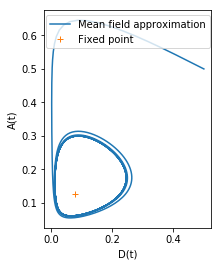

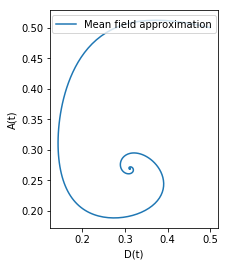

In [100]:
for a in [0.1,0.5]:
    f = plt.figure()
    f.set_size_inches(3,4)
    plt.xlabel('D(t)')
    plt.ylabel('A(t)')
    t,x=ddpp.ode(time=10)
    plt.plot(x[:,0],x[:,1])
    if a==0.1:
        plt.plot([0.078],[0.126],'+')
    plt.legend(('Mean field approximation','Fixed point'),loc='upper center')
    f.savefig('SIR_2D_a0{}.pdf'.format(int(a*10)),bbox_inches='tight')